<center>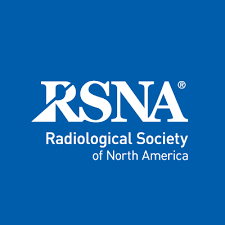
</center>

<font color="red" size=5><center>RSNA-STR Pulmonary Embolism Detection</center></font>

# Introduction 

In this notebook I will dwell about DICOM files and CT Scans. Also we will visualize the tabular data using seaborn and matplotlib. We will even extract the important metadata that can be used as input to models.

The metadata will be provided as CSV. 
To access the CSV please click this [LINK](https://www.kaggle.com/nitindatta/pulmonary-embolism-ct-data)

### **What is Pulmonary Embolism?**
* Pulmonary embolism (PE) is a blockage of an artery in the lungs by a substance that has moved from elsewhere in the body through the bloodstream (embolism). 
* Symptoms of a PE may include shortness of breath, chest pain particularly upon breathing in, and coughing up blood. 
* Most times, a pulmonary embolism is caused by blood clots that travel from the legs, or rarely, other parts of the body (deep vein thrombosis or DVT).

Watch the video below to get some insights about it..

<font color="red" size=3>Please upvote this kernel if you like it. It motivates me to produce more quality content :)</font>

In [ ]:
from IPython.display import HTML
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/Sm7GX5vNQ0k?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

<a class="anchor" id="toc"></a>
<div style="background: #f9f9f9 none repeat scroll 0 0;border: 1px solid #aaa;display: table;font-size: 95%;margin-bottom: 1em;padding: 20px;width: 600px;">
<h1>Contents</h1>
<ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
<li style="list-style: outside none none !important;font-size:17px"><a href="#1.1">1 Data Preparation</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
            <li style="list-style: outside none none !important;"><a href="#1.1">1.1 Importing Dependencies</a></li>
            <li style="list-style: outside none none !important;"><a href="#1.2">1.2 Reading our CSV files 📁</a></li>
            <li style="list-style: outside none none !important;"><a href="#1.3">1.3 Data Fields📊</a></li>
            <li style="list-style: outside none none !important;"><a href="#1.4">1.4 Insights about our data</a></li>
            <li style="list-style: outside none none !important;"><a href="#1.5">1.5 Any Missing Values (❔)(❔)(❔)</a></li>
      </ul>
<li style="list-style: outside none none !important;font-size:17px"><a href="#2.1">2 Diving into CT Scans</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
            <li style="list-style: outside none none !important;"><a href="#2.1">2.1 Loading the scans ■■■■■■■■■■■□□□</a></li>
            <li style="list-style: outside none none !important;"><a href="#2.2">2.2 Understanding more about Hounsfield Units</a></li>
            <li style="list-style: outside none none !important;"><a href="#2.3">2.3 Utility Functions</a></li>
           <li style="list-style: outside none none !important;"><a href="#2.4">2.4 Sorting our slices and GIF creation</a></li>
           <li style="list-style: outside none none !important;"><a href="#2.5">2.5 3D Reconstruction using slices</a></li>
            <li style="list-style: outside none none !important;"><a href="#2.6">2.6 Extracting DICOM data</a></li>
      </ul>
    
<li style="list-style: outside none none !important;font-size:17px"><a href="#3.1">3 Light EDA</a></li>
<li style="list-style: outside none none !important;font-size:17px"><a href="#4">4 Acknowledgements</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">    

</ul>
</div>

# Data Preparation
## Importing dependencies
<a class="anchor" id="1.1"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>

In [ ]:
!conda install -c conda-forge gdcm -y

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import HTML

sns.set_style('darkgrid')
import pydicom
import scipy.ndimage
import gdcm
import imageio
from IPython import display


from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.morphology import disk, opening, closing
from tqdm import tqdm

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from os import listdir, mkdir

In [ ]:
basepath = "../input/rsna-str-pulmonary-embolism-detection/"
listdir(basepath)

 ## Reading our CSV files 📁
 <a class="anchor" id="1.2"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>

In [ ]:
train = pd.read_csv(basepath + "train.csv")
test = pd.read_csv(basepath + "test.csv")

## Data fields 📊
<a class="anchor" id="1.3"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>

NOTE: You can find this on the competition page but still I am presenting it here

* `StudyInstanceUID` - unique ID for each study (exam) in the data.
* `SeriesInstanceUID` - unique ID for each series within the study.
* `SOPInstanceUID` - unique ID for each image within the study (and data).
* `pe_present_on_image` - image-level, notes whether any form of PE is present on the image.
* `negative_exam_for_pe` - exam-level, whether there are any images in the study that have PE present.
* `qa_motion` - informational, indicates whether radiologists noted an issue with motion in the study.
* `qa_contrast` - informational, indicates whether radiologists noted an issue with contrast in the study.
* `flow_artifact` - informational
* `rv_lv_ratio_gte_1` - exam-level, indicates whether the RV/LV ratio present in the study is >= 1
* `rv_lv_ratio_lt_1` - exam-level, indicates whether the RV/LV ratio present in the study is < 1
* `leftsided_pe` - exam-level, indicates that there is PE present on the left side of the images in the study
* `chronic_p`e - exam-level, indicates that the PE in the study is chronic
* `true_filling_defect_not_pe` - informational, indicates a defect that is NOT PE
* `rightsided_pe` - exam-level, indicates that there is PE present on the right side of the images in the study
* `acute_and_chronic_pe` - exam-level, indicates that the PE present in the study is both acute AND chronic
* `central_pe` - exam-level, indicates that there is PE present in the center of the images in the study
* `indeterminate` -exam-level, indicates that while the study is not negative for PE, an ultimate set of exam-level labels could not be created, due to QA issues

## Insights about our data
<a class="anchor" id="1.4"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>

Few sanity checks about data such astype of each column, memory occupied etc.

In [ ]:
train.shape, test.shape

In [ ]:
train.head().T

In [ ]:
train.info()

In [ ]:
test.info()

📌 We are dealing with approximately 240 MB of tabular data

In [ ]:
print("Number of unique Study instances are", train['StudyInstanceUID'].nunique())
print("Number of unique Series instances are", train['SeriesInstanceUID'].nunique())

📌 As both Study and Series are the same number we can infer that there is only one series for each study.


## Any Missing Values (❔)(❔)(❔)

<a class="anchor" id="1.5"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>

Now we will see if there are any null values or not

In [ ]:
print('Null values in train data:',train.isnull().sum().sum())
print('Null values in test data:',test.isnull().sum().sum())

📌 No missing values and clean data

# Diving into CT-scans

## Loading the scans ■■■■■■■■■■■□□□
<a class="anchor" id="2.1"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>

In [ ]:
def load_scans(dcm_path):
    files = listdir(dcm_path)
    f = [pydicom.dcmread(dcm_path + "/" + str(file)) for file in files]
    return f

In [ ]:
example = basepath + "train/" + train.StudyInstanceUID.values[0] +'/'+ train.SeriesInstanceUID.values[0]
file_names = listdir(example)

In [ ]:
scans = load_scans(example)

Let us take a look at an example of dicom data

In [ ]:
scans[0]

Few details about CT Scans: 

* CT-scan captures information about the radiodensity of an object or tissue exposed to x-rays.A transversal slice of a scan is reconstructed after taking measurements from several different directions.
* We use something called as  **Hounsfield Units** which is defined as *Relative quantitative measurement of radio density used by radiologists in the interpretation of computed tomography (CT) images*
* The CT-scans are already in the HU format
* ct-scanner yields roughly 4000 grey values that can't be captured by our eyes. So we perform something called as windowing.
* Water has HU 0 and Air -1000

If you dont know all these details do not worry please watch the below video to understand more about CT windows, HU etc.

📌 For the main content jump to the 7th minute

## Understanding more about Hounsfield Units
<a class="anchor" id="2.2"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>


In [ ]:
from IPython.display import HTML
HTML('<center><iframe width="700" height="400" src="https://www.youtube.com/embed/KZld-5W99cI?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe></center>')

In [ ]:
plt.figure(figsize=(12,6))
for n in range(10):
    image = scans[n].pixel_array.flatten()
    rescaled_image = image * scans[n].RescaleSlope + scans[n].RescaleIntercept
    sns.distplot(image.flatten());
plt.title("HU unit distributions for 10 examples");

📌 In the above graph we have plotted pixel distributions of 5 examples. 

Next we will look at pixel array distribution along with the CT scan Image

## Utility Functions
<a class="anchor" id="2.3"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>


In [ ]:
def load_slice(path):
    slices = [pydicom.read_file(path + '/' + s) for s in listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    images[images <= -1000] = 0
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([float(scans_0[0].SliceThickness), 
                        float(scans_0[0].PixelSpacing[0]), 
                        float(scans_0[0].PixelSpacing[0])])


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def make_mesh(image, threshold=-300, step_size=1):
    p = image.transpose(2,1,0)
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    return verts, faces


def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
#     ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    ax.set_facecolor((0.7,0.7,0.7))
    plt.show()


In [ ]:
sns.set_style('white')
hu_scans = transform_to_hu(scans)

fig, ax = plt.subplots(1,2,figsize=(15,4))


ax[0].set_title("CT-scan in HU")
ax[0].imshow(hu_scans[0], cmap="plasma")
ax[1].set_title("HU values distribution");
sns.distplot(hu_scans[0].flatten(), ax=ax[1],color='red', kde_kws=dict(lw=2, ls="--",color='blue'));
ax[1].grid(False)

📌 From the graph we can infer that most of the area is filled with air as air has HU around -1000 and the next highest is water: HU around 0

## Sorting our slices and GIF creation
<a class="anchor" id="2.4"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>


In [ ]:
first_patient = load_slice('../input/rsna-str-pulmonary-embolism-detection/train/0003b3d648eb/d2b2960c2bbf')
first_patient_pixels = transform_to_hu(first_patient)

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='bone')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(first_patient_pixels)

We are arranging the slices in order and skipping 5 slices at a time to look at wider variety of slices

In [ ]:
imageio.mimsave("/tmp/gif.gif", first_patient_pixels, duration=0.1)
display.Image(filename="/tmp/gif.gif", format='png')

## 3D Reconstruction using slices
<a class="anchor" id="2.5"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>


In [ ]:
first_patient_scan = '../input/rsna-str-pulmonary-embolism-detection/train/0003b3d648eb/d2b2960c2bbf'
scans_0 = load_scans(first_patient_scan)
imgs_after_resamp, spacing = resample(first_patient_pixels, scans_0, [1,1,1])
v, f = make_mesh(imgs_after_resamp, threshold = 350)
plt_3d(v, f)

In [ ]:
im_path = []
train_path = '../input/rsna-str-pulmonary-embolism-detection/train/'
for i in listdir(train_path): 
    for j in listdir(train_path + i):
        x = i+'/'+j
        im_path.append(x)

## Extracting DICOM data
<a class="anchor" id="2.6"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>

In [ ]:
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
ids = []
id_pth = []
row_values = []
column_values = []
window_widths = []
window_levels = []
modality = []
kvp = []
table_height = []
x_ray_tube = []
exp = []
pos = []
tilt = []
bits = []
rescale_inter = []
rescale_slope = []
photometric_interpretation = []
convolution_kernel = [] 


for i in im_path:
    ids.append(i.split('/')[0]+'_'+i.split('/')[1])
    example_dcm = listdir(train_path  + i + "/")[0]
    id_pth.append(train_path + i)
    dataset = pydicom.dcmread(train_path + i + "/" + example_dcm)
    
    window_widths.append(get_window_value(dataset.WindowWidth))
    window_levels.append(get_window_value(dataset.WindowCenter))
    
    spacing = dataset.PixelSpacing
    slice_thicknesses.append(dataset.SliceThickness)
    
    row_values.append(dataset.Rows)
    column_values.append(dataset.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])
    
    modality.append(dataset.Modality)
    kvp.append(dataset.KVP)
    table_height.append(dataset.TableHeight)
    x_ray_tube.append(dataset.XRayTubeCurrent)
    exp.append(dataset.Exposure)
    pos.append(dataset.PatientPosition)
    tilt.append(dataset.GantryDetectorTilt)
    bits.append(dataset.BitsAllocated)
    rescale_inter.append(dataset.RescaleIntercept)
    rescale_slope.append(dataset.RescaleSlope)
    photometric_interpretation.append(dataset.PhotometricInterpretation)
    convolution_kernel.append(dataset.ConvolutionKernel)
    
scan_properties = pd.DataFrame(data=ids, columns=["ID"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "id_pth"] = id_pth
scan_properties.loc[:, "window_width"] = window_widths
scan_properties.loc[:, "window_level"] = window_levels
scan_properties.loc[:, "modality"] = modality
scan_properties.loc[:, "kvp"] = kvp
scan_properties.loc[:, "table_height"] = table_height
scan_properties.loc[:, "x_ray_tube_current"] = x_ray_tube
scan_properties.loc[:, "exposure"] = exp 
scan_properties.loc[:,"patient_position"] = pos
scan_properties.loc[:,"detector_tilt"] = tilt
scan_properties.loc[:,"bits_allocated"] = bits
scan_properties.loc[:,"rescale_intercept"] = rescale_inter
scan_properties.loc[:, "rescale_slope"] = rescale_slope
scan_properties.loc[:, "photometric_interpretation"] = photometric_interpretation
scan_properties.loc[:, "convolution_kernel"] = convolution_kernel

scan_properties.head().T

### Pixelspacing
* The pixelspacing attribute you can find in the dicom files is an important one. It tells us how much physical distance is covered by one pixel. You can see that there are only 2 values that describe the x- and y-direction in the plane of a transversal slice.
* For one patient this pixelspacing is usually the same for all slices.
* But between patients the pixelspacing can differ due to personal or institutional preferences of doctors and the clinic and it also depends on the scanner type. Consequently if you compare two images in the size of the lungs it does not automatically mean that the bigger one is really larger in the physical size of the organ!

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_r, ax=ax[0], color='green', kde_kws=dict(lw=3, ls="--",color='red'))
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("mm")
sns.distplot(pixelspacing_c, ax=ax[1], color="Blue",kde_kws=dict(lw=3, ls="--",color='red'))
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("mm");

We can see that the values really vary a lot from patient to patient! As they are given in mm and ct-scans usually cover 512 row and column values

### Physical area & slice volume covered by a single ct-scan

Now, we know some important quantities to compute the physical distance covered by a ct-scan!

In [ ]:
scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(scan_properties.area_cm2, ax=ax[0], color="Limegreen",kde_kws=dict(lw=3, ls="--",color='red'))
sns.distplot(scan_properties.slice_volume_cm3, ax=ax[1], color="Mediumseagreen",kde_kws=dict(lw=3, ls="--",color='red'))
ax[0].set_title("CT-slice area in $cm^{2}$")
ax[1].set_title("CT-slice volume in $cm^{3}$")
ax[0].set_xlabel("$cm^{2}$")
ax[1].set_xlabel("$cm^{3}$");

In [ ]:
scan_properties.head(3).T

In [ ]:
scan_properties.describe().T

In [ ]:
scan_properties.dtypes

In [ ]:
scan_properties.to_csv('Pulmonary_Embolism_CT_scans_data.csv',index=False)

# Light EDA
<a class="anchor" id="3.1"></a>
<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go To Table of Contents</a>


In [ ]:
scan_cols = scan_properties.copy()
scan_cols.drop(['rows','columns','area','detector_tilt','bits_allocated','rescale_slope'],axis=1,inplace=True)

corr = scan_cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.8,cmap="viridis",annot=True)

We can see an unusual heatmap this is because:

📌 Most of our values are dervied which makes some features highly correlated

In [ ]:
y_cols = ['pixelspacing_r','pixelspacing_c','pixelspacing_area']
x_cols = 'slice_volume_cm3'

plt.figure(figsize=(18,6))
for i in range(len(y_cols)):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=x_cols,y=y_cols[i],data=scan_cols,hue='slice_thickness',size='slice_thickness')

📌 Slice_thickness is directly proportional to the volume

In [ ]:
cols = train.copy()
cols.drop(['StudyInstanceUID','SeriesInstanceUID','SOPInstanceUID'],axis=1,inplace=True)
columns = cols.columns

In [ ]:
fig, ax = plt.subplots(7,2,figsize=(16,28))
for i,col in enumerate(columns): 
    plt.subplot(7,2,i+1)
    sns.countplot(cols[col],palette='hot')   

In [ ]:
corr = cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.8,cmap="summer",annot=True)

# Acknowledgements
<a class="anchor" id="4"></a>

1. [Excellent work of Laura Fink](https://www.kaggle.com/allunia/pulmonary-fibrosis-dicom-preprocessing)
2. [Insights used by prk007](https://www.kaggle.com/prk007/insights-from-tabular-and-image-data)
3. [3D reconstruction by Md. Redwan Karim Sony](https://www.kaggle.com/redwankarimsony/rsna-str-3d-stacking-3d-plot-segmentation/comments)


<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Back to Table of Contents</a>

<font color="chocolate" size=+2.5><b>My Other Kernels</b></font>

Click on the button to view kernel...


<a href="https://www.kaggle.com/nitindatta/fifa-in-depth-analysis-with-linear-regression" class="btn btn-success" style="color:white;">FIFA In-Depth Analysis</a><br><br>

<a href="https://www.kaggle.com/nitindatta/ensemble-learning-part-1" class="btn btn-success" style="color:white;">Ensemble Learning Part 1</a><br><br>

<a href="https://www.kaggle.com/nitindatta/ensemble-learning-part-2" class="btn btn-success" style="color:white;">Ensemble Learning Part 2</a><br><br>

<a href="https://www.kaggle.com/nitindatta/students-performance-in-exams-eda-in-depth" class="btn btn-success" style="color:white;">Students performance in Exams- EDA in depth 📊📈</a><br><br>

<a href="https://www.kaggle.com/nitindatta/pulmonary-embolism-dicom-preprocessing-eda" class="btn btn-success" style="color:white;">🩺Pulmonary Embolism Dicom preprocessing & EDA🩺</a><br><br>

<a href="https://www.kaggle.com/nitindatta/first-kaggle-submission" class="btn btn-success" style="color:white;">Titanic: Machine Learning from Disaster</a><br><br>

<a href="https://www.kaggle.com/nitindatta/graduate-admission-chances" class="btn btn-success" style="color:white;">📖 Graduate Admission Chances 📕 📔</a><br><br>

<a href="https://www.kaggle.com/nitindatta/flower-classification-augmentations-eda" class="btn btn-success" style="color:white;">Flower_Classification+Augmentations+EDA</a><br><br>

<a href="https://www.kaggle.com/nitindatta/storytelling-with-gwd-pre-print-data" class="btn btn-success" style="color:white;">Storytelling with GWD pre_print data</a><br><br>


### If these kernels impress you,give them an <font size="+2" color="red"><b>Upvote</b></font>.<br>

<a href="#toc" class="btn btn-primary" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>

<font color="red" size=5><center>🚧WORK UNDER PROGRESS🚧</center></font>